In [1]:
# %%
import matplotlib.pyplot as plt
from ANN_models import PredictionModel, PredictionModel2
import os 
import json
import torch
import numpy as np
import sys
import matplotlib as mpl
# Default settings
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("seaborn-darkgrid")

# %%
result_folder = "prediction_model2_formula2"
subject = 'ctchen'

C:\Users\dicky1031\AppData\Local\Temp\ipykernel_22312\986087595.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


In [2]:
def cal_R_square(y_true, y_pred):
    y_bar = np.mean(y_true)
    numerator = np.sum(np.square(y_true-y_pred))
    denominator = np.sum(np.square(y_true-y_bar))
    R_square = 1 - numerator/denominator
    
    return R_square
# %%
os.makedirs(os.path.join("pic", subject, result_folder), exist_ok=True)
with open(os.path.join("OPs_used", "SO2.json"), 'r') as f:
    SO2 = json.load(f)
    test_SO2 = SO2['test_SO2']
with open(os.path.join("model_save", subject, result_folder, 'trlog.json'), 'r') as f:
    config = json.load(f)
test_loader = torch.load(os.path.join("model_save", subject, result_folder, 'test_loader.pth'))
model = PredictionModel2().cuda()
model.load_state_dict(torch.load(config['best_model']))
model.eval()

PredictionModel2(
  (net): Sequential(
    (0): Linear(in_features=40, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [ ]:
# %%
plt.figure()
for batch_idx, (data,target, parameters, _) in enumerate(test_loader):
    data,target = data.to(torch.float32).cuda(), target.to(torch.float32).cuda()
    output = model(data)
    output = output.detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    if batch_idx == 0:
        error = 100*np.abs(output - target)
        RMSE = 100*(output - target)
    else:
        error = np.concatenate((error, 100*np.abs(output - target)))
        RMSE = np.concatenate((RMSE, 100*(output - target)))
    plt.plot(target,output, 'r.', markersize=5)
    plt.plot(target,target,'b')

RMSE = np.sqrt(np.mean(np.square(RMSE)))
mean = np.mean(error)
std = np.std(error)
max_error = np.max(error)
plt.title(f"based on SO2=70% \nmean error:{mean:.2f}% std:{std:.2f}% \nmax error:{max_error:.2f}% RMSE:{RMSE:.2f}%")
plt.xlabel("truth $\u0394$SO2")
plt.ylabel("predict $\u0394$SO2")
plt.savefig(os.path.join("pic", subject, result_folder, "RMSE_all_metrics.png"), dpi=300, format='png', bbox_inches='tight')
# plt.close()
plt.show()

#%%
plt.figure()
for batch_idx, (data,target, parameters, _) in enumerate(test_loader):
    data,target = data.to(torch.float32).cuda(), target.to(torch.float32).cuda()
    output = model(data)
    output = output.detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    if batch_idx == 0:
        error = 100*(output - target)
        accumulate_RMSE = 100*(output - target)
        accumulate_output = output
        accumulate_target = target
    else:
        error = np.concatenate((error, 100*(output - target)))
        accumulate_RMSE = np.concatenate((accumulate_RMSE, 100*(output - target)))
        accumulate_output = np.concatenate((accumulate_output, output))
        accumulate_target = np.concatenate((accumulate_target, target))
    if batch_idx == 0:
        plt.plot(target*100,output*100, 'r.', markersize=5, label= 'predict')
        plt.plot(target*100,target*100,'b', label = 'optimal')
    else:
        plt.plot(target*100,output*100, 'r.', markersize=5)
        plt.plot(target*100,target*100,'b')

RMSE = np.sqrt(np.mean(np.square(accumulate_RMSE)))
R_square = cal_R_square(y_true=accumulate_target, y_pred=accumulate_output)
plt.title(f"based on SO2=70% \n RMSE:{RMSE:.2f}% $R^{2}$:{R_square:.3f}")
plt.xlabel("truth $\u0394$SO2(%)")
plt.ylabel("predict $\u0394$SO2(%)")
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True)
plt.savefig(os.path.join("pic", subject, result_folder, "RMSE.png"), dpi=300, format='png', bbox_inches='tight')
plt.close()
# plt.show()

#%%
table = {}
for using_SO2 in test_SO2:
    table[using_SO2] = []
for i in range(accumulate_target.shape[0]):
    key = np.around(accumulate_target[i][0] + 0.7,2)
    table[key] += [accumulate_output[i][0]-accumulate_target[i][0]]

accumulate_std1 = []
accumulate_std2 = []
accumulate_x = []
for key in table.keys():
    data = np.array(table[key])
    std1 = max(data)
    std2 = min(data)
    # std1 = np.std(data[np.where(data>=0)])
    # std2 = np.std(data[np.where(data<=0)])
    if np.isnan(std1):
        std1 = 0
    if np.isnan(std2):
        std2 = 0
    ijv_change = np.around(key - 0.7, 2)
    accumulate_std1.append(std1)
    accumulate_std2.append(std2)
    accumulate_x.append(ijv_change)
accumulate_std1 = np.array(accumulate_std1)*100
accumulate_std2 = np.array(accumulate_std2)*100
accumulate_x = np.array(accumulate_x)*100

plt.figure()
plt.fill_between(accumulate_x, accumulate_x+accumulate_std1, accumulate_x+accumulate_std2, color='b', alpha=0.3, edgecolor=None, label='predict')
plt.plot(accumulate_x,accumulate_x, 'b', label='optimal')
plt.title(f"based on SO2=70% \n RMSE:{RMSE:.2f}% $R^{2}$:{R_square:.3f}")
plt.xlabel("truth $\u0394$SO2(%)")
plt.ylabel("predict $\u0394$SO2(%)")
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True)
plt.savefig(os.path.join("pic", subject, result_folder, "RMSE_fill_plot.png"), dpi=300, format='png', bbox_inches='tight')
# plt.close()
plt.show()

# %%
for batch_idx, (data,target, parameters, _) in enumerate(test_loader):
    data,target = data.to(torch.float32).cuda(), target.to(torch.float32).cuda()
    output = model(data)
    output = output.detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    if batch_idx == 0:
        error = 100*(output - target)
        RMSE = 100*(output - target)
    else:
        error = np.concatenate((error, 100*(output - target)))
        RMSE = np.concatenate((RMSE, 100*(output - target)))

mean = np.mean(error)
std = np.std(error)
plt.figure()
n,bin, pack = plt.hist(error, bins=50)
plt.vlines([mean+2*std, mean-2*std], 0, max(n), 'r', label='$\mu$$\pm$2*$\sigma$')
plt.text(mean+2*std, max(n)+20, f'{mean+2*std:.2f}%')
plt.text(mean-2*std, max(n)+20, f'{mean-2*std:.2f}%')
plt.xlabel('error(prediction-true)')
plt.ylabel('count')
plt.title('error histogram')
plt.legend()
plt.savefig(os.path.join("pic", subject, result_folder, "hist.png"), dpi=300, format='png', bbox_inches='tight')
# plt.close()
plt.show()


In [53]:
# %%
table = {}
for batch_idx, (data,target, parameters, muscle_SO2) in enumerate(test_loader):
    for idx, single_muscle_SO2 in enumerate(muscle_SO2):
        table[float(single_muscle_SO2.numpy())] = 0
    data,target = data.to(torch.float32).cuda(), target.to(torch.float32).cuda()
    output = model(data)
    output = output.detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    for i in range(target.shape[0]):
        table[int(target[i]*100)] = []
            
for batch_idx, (data,target, parameters, muscle_SO2) in enumerate(test_loader):
    data,target = data.to(torch.float32).cuda(), target.to(torch.float32).cuda()
    output = model(data)
    output = output.detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    for i in range(target.shape[0]):
        table[int(target[i]*100)].append(list(100*(output[i] - target[i]))[0])


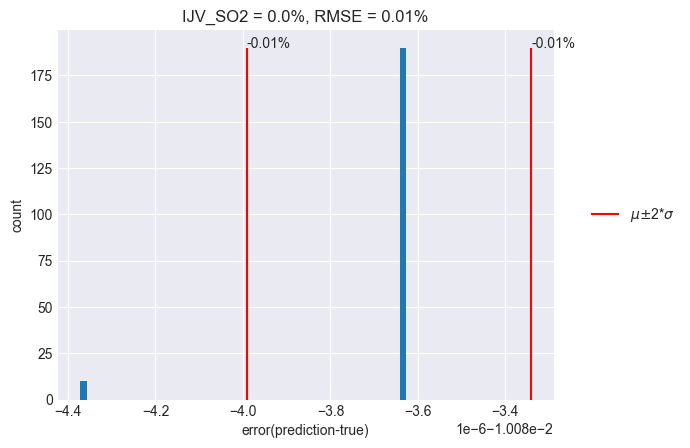

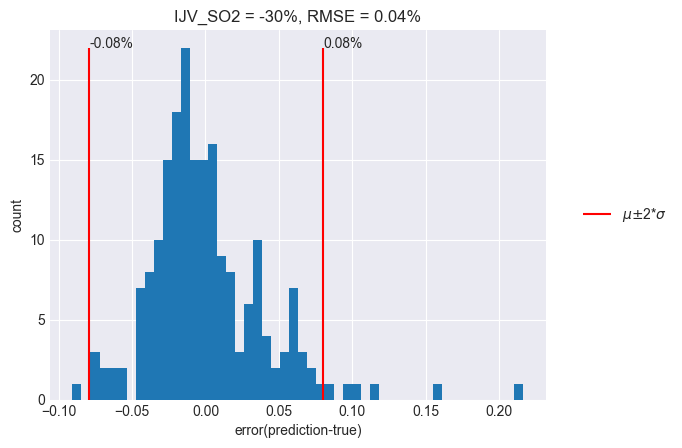

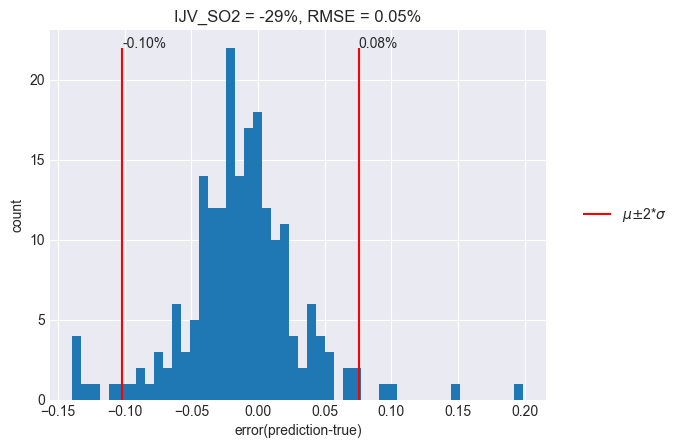

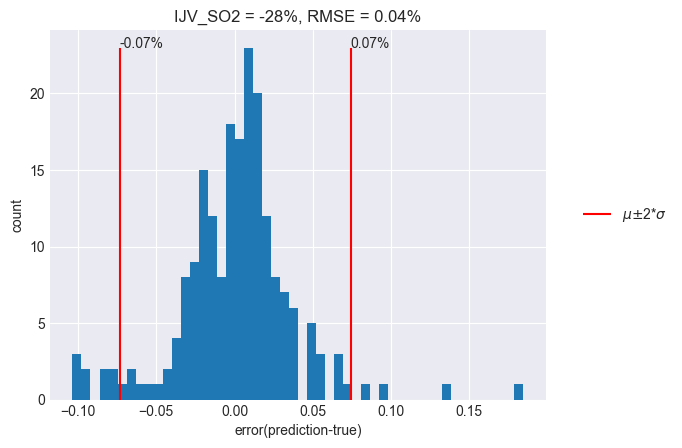

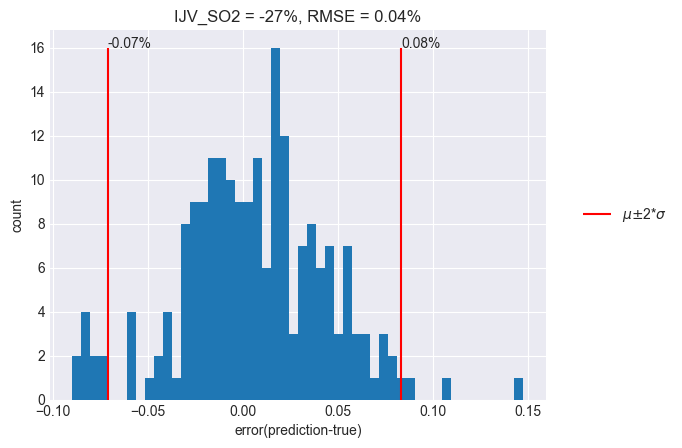

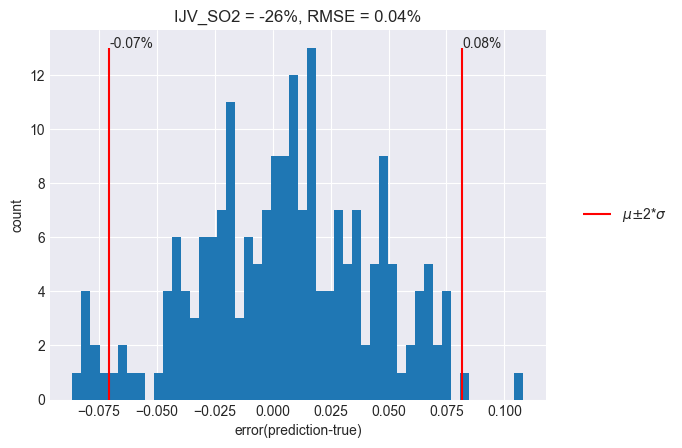

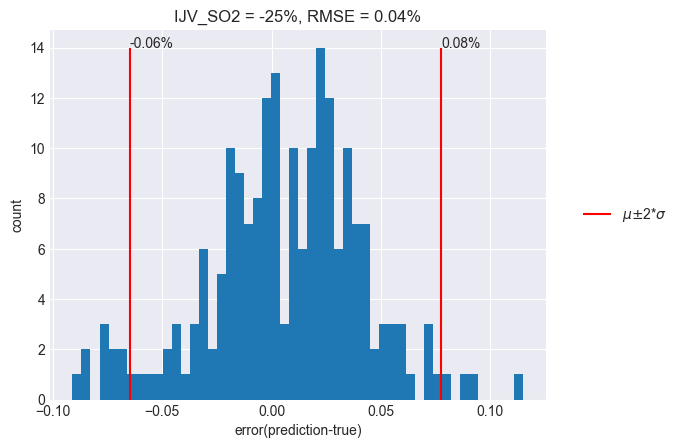

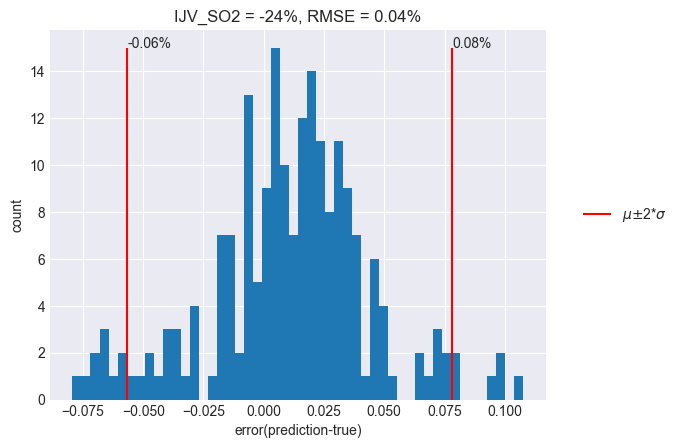

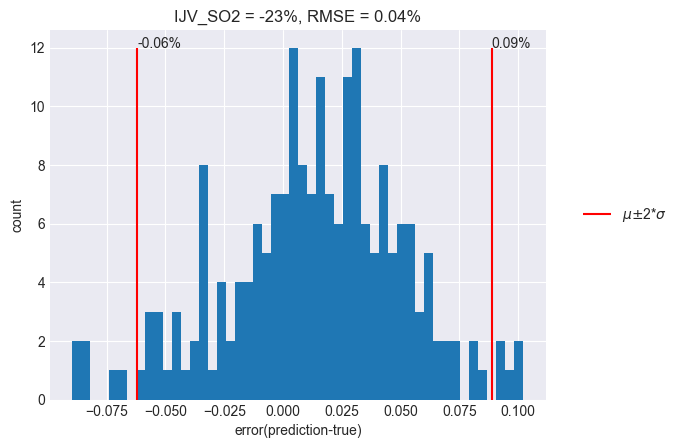

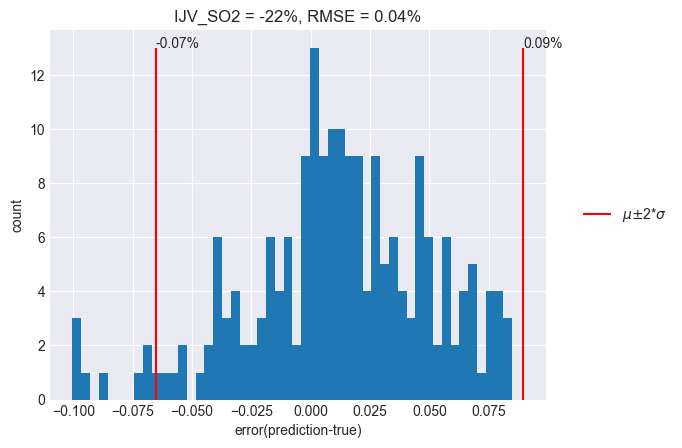

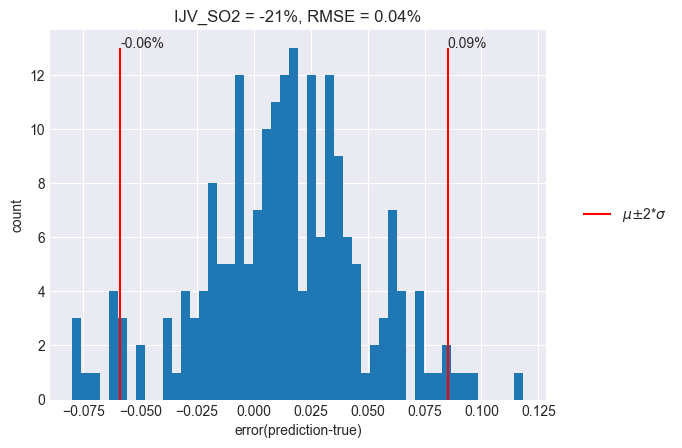

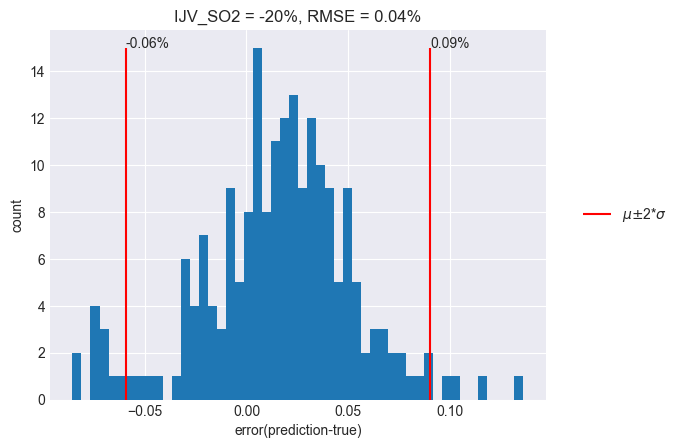

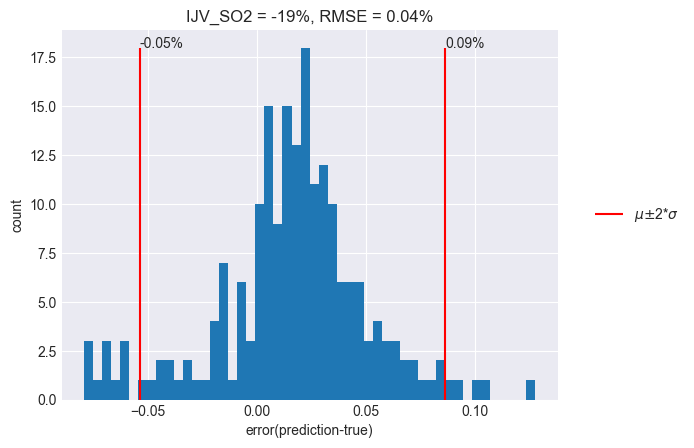

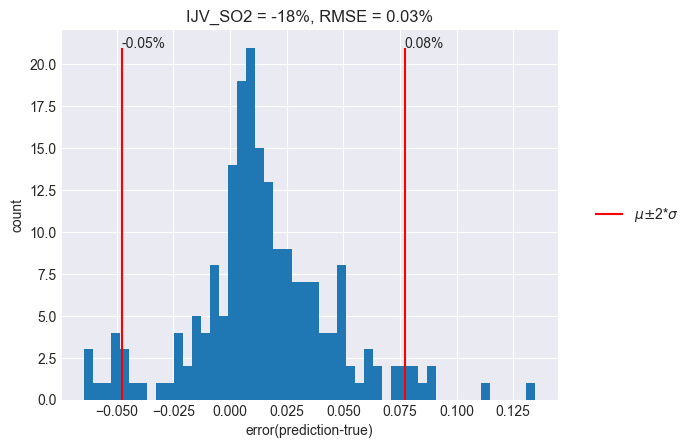

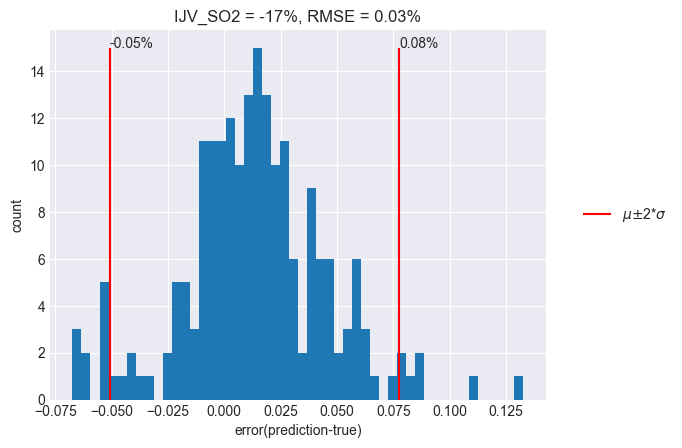

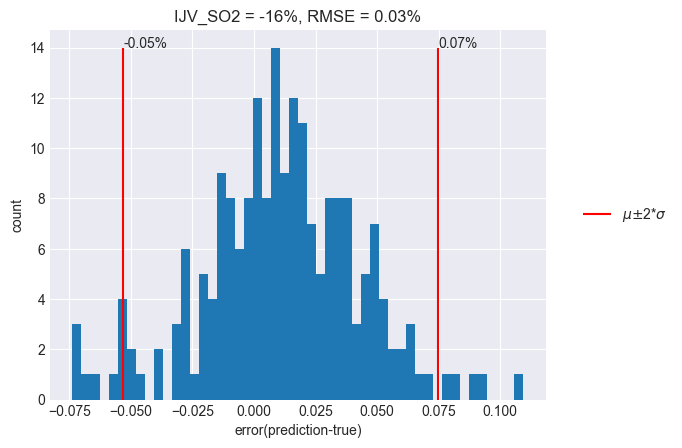

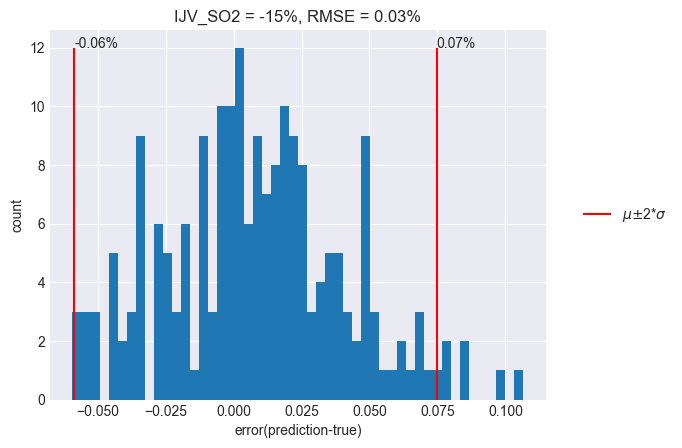

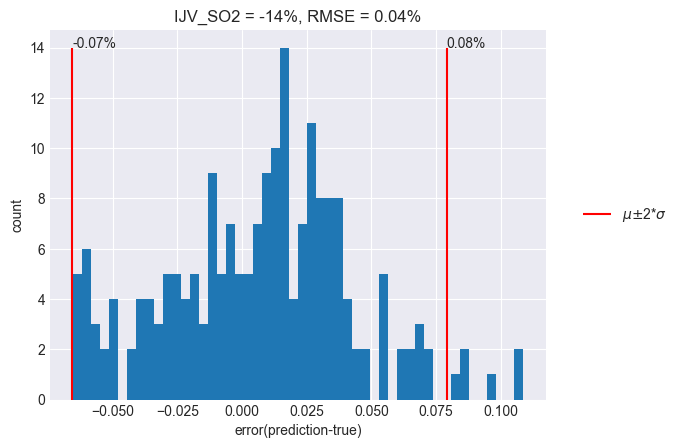

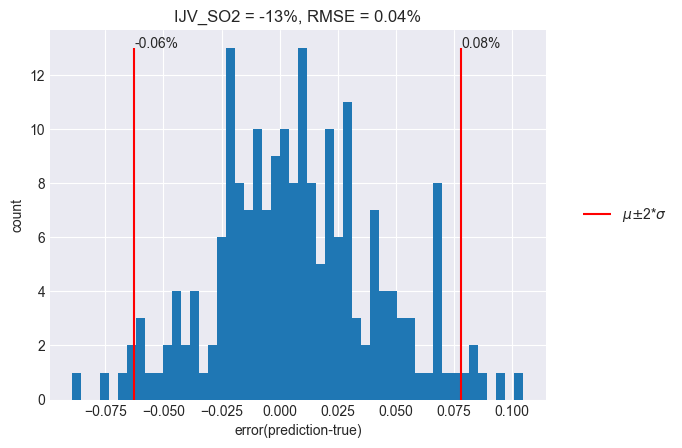

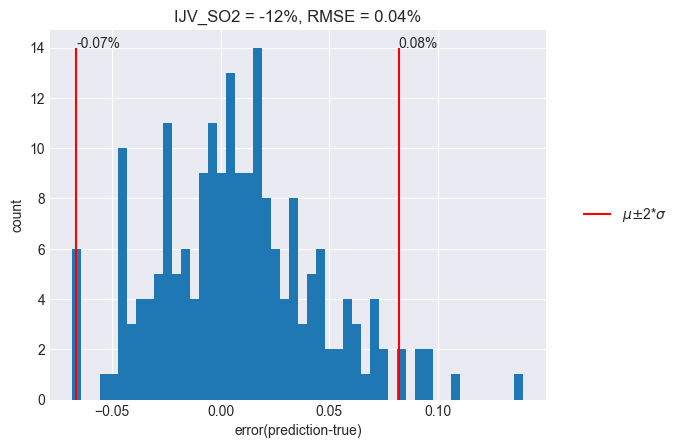

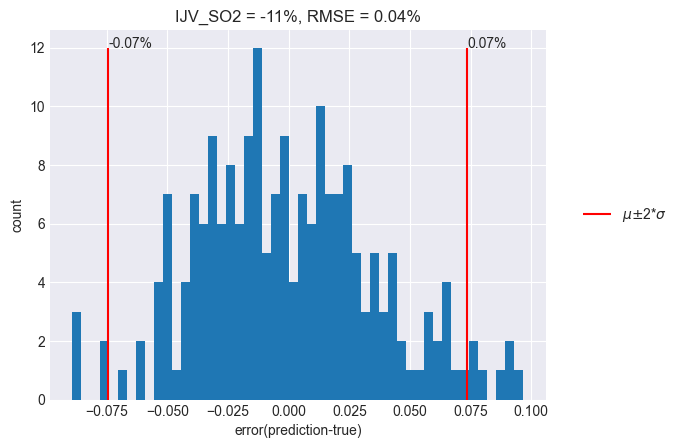

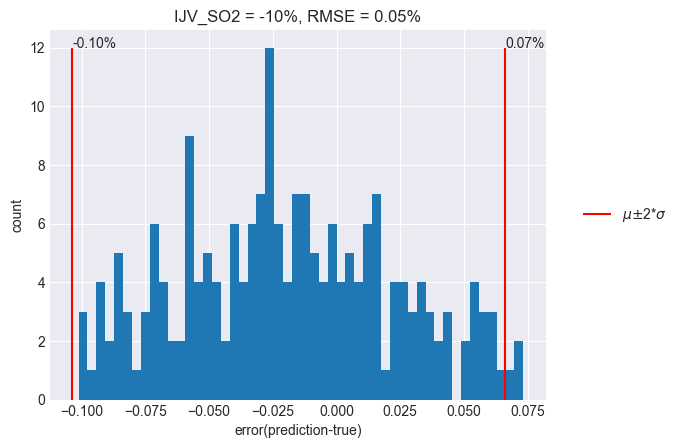

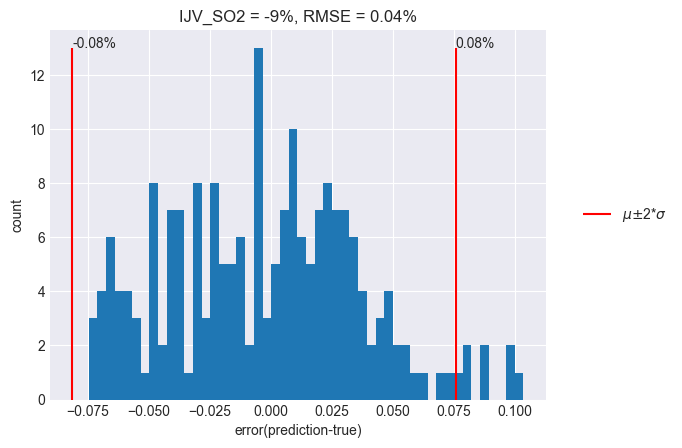

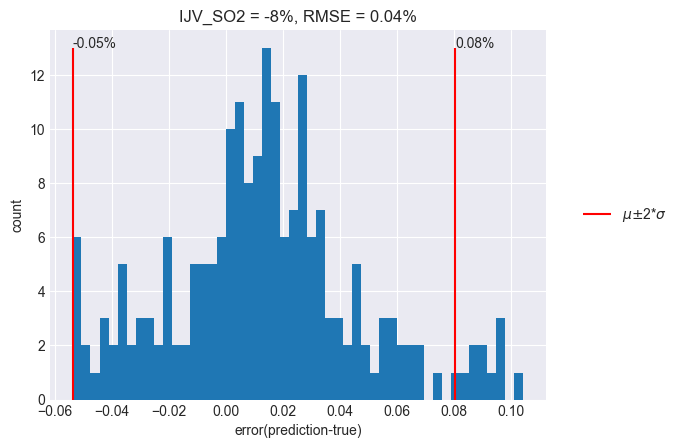

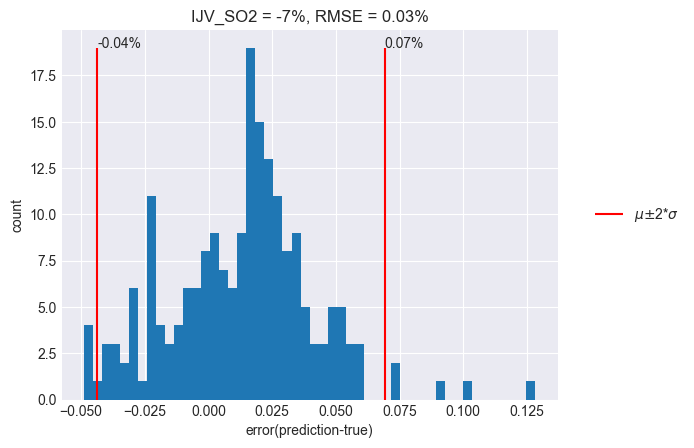

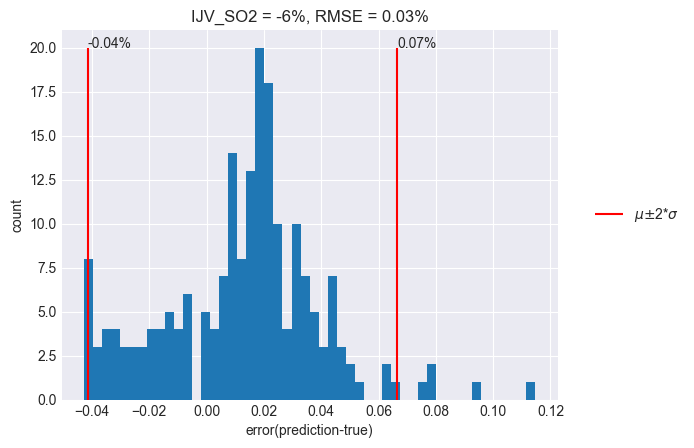

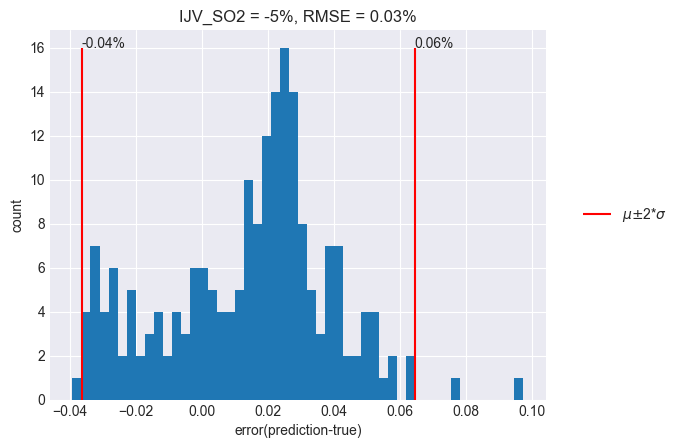

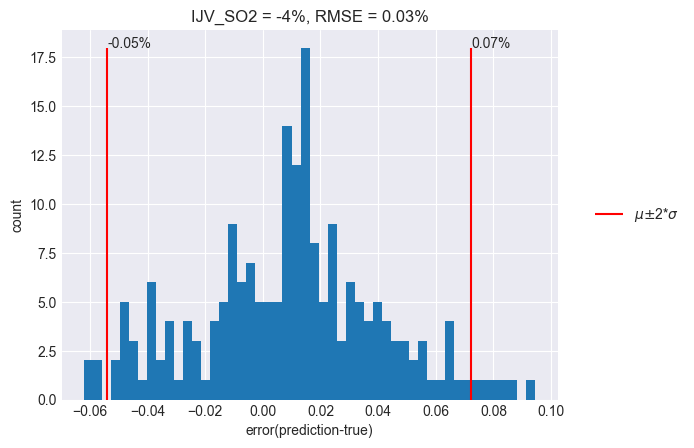

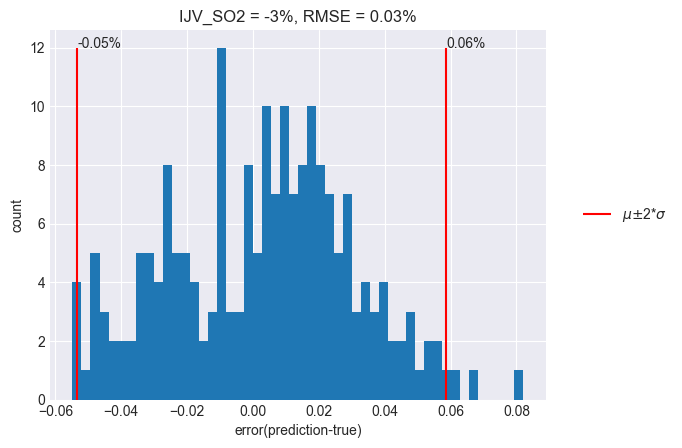

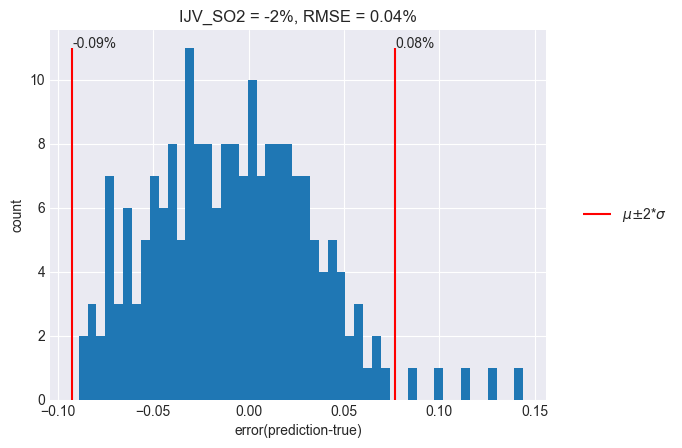

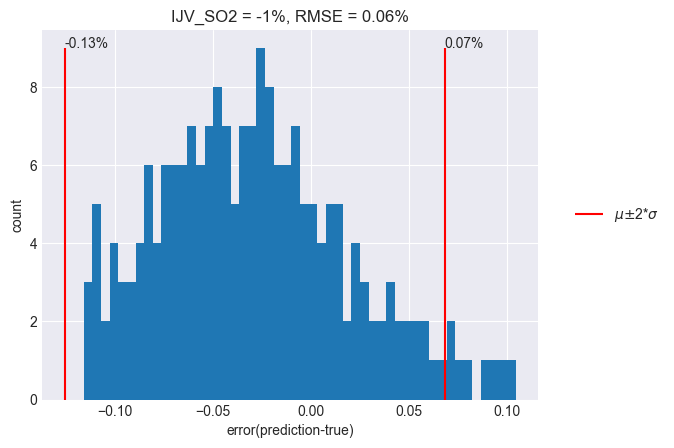

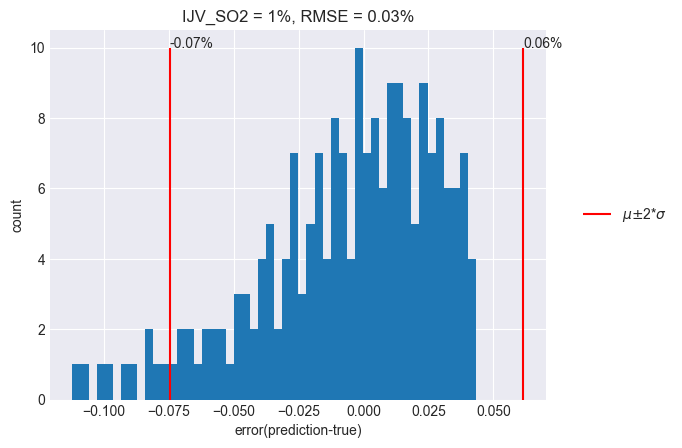

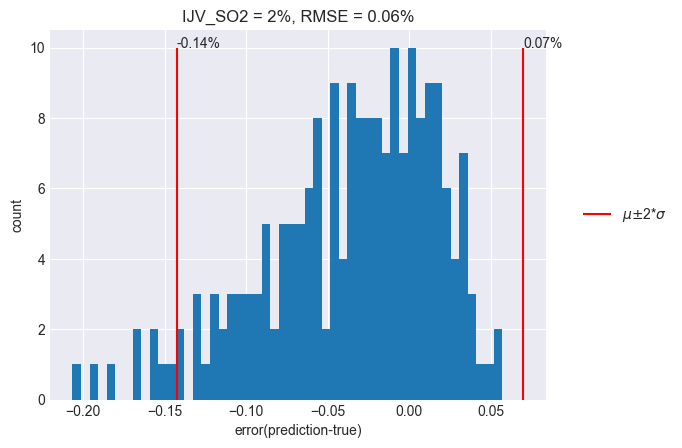

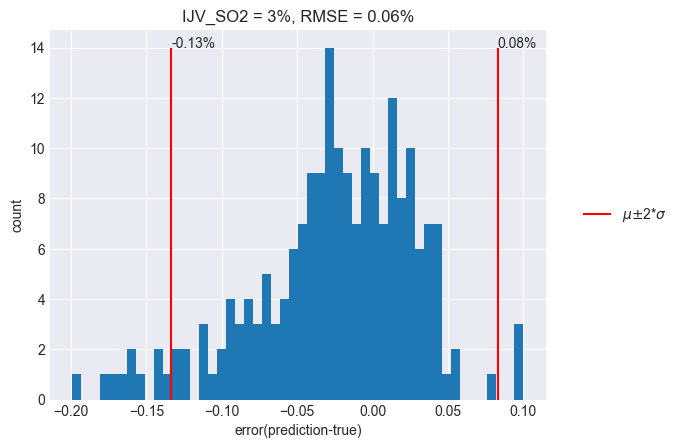

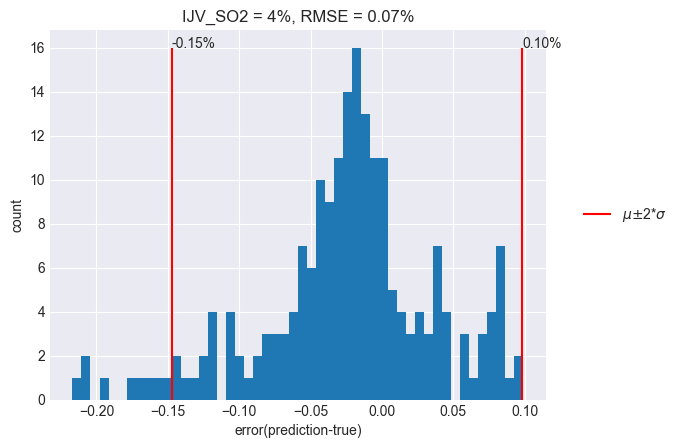

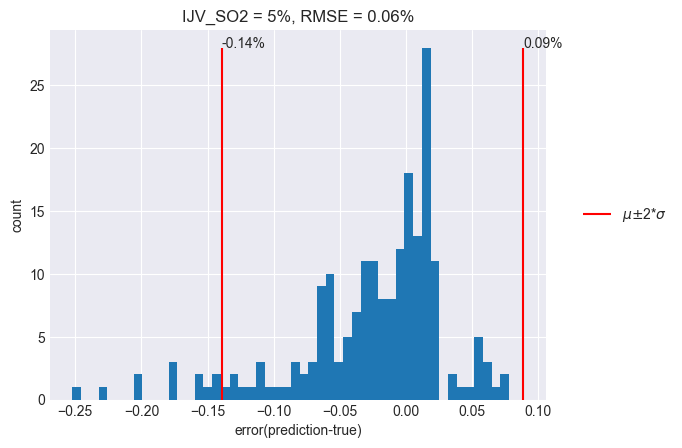

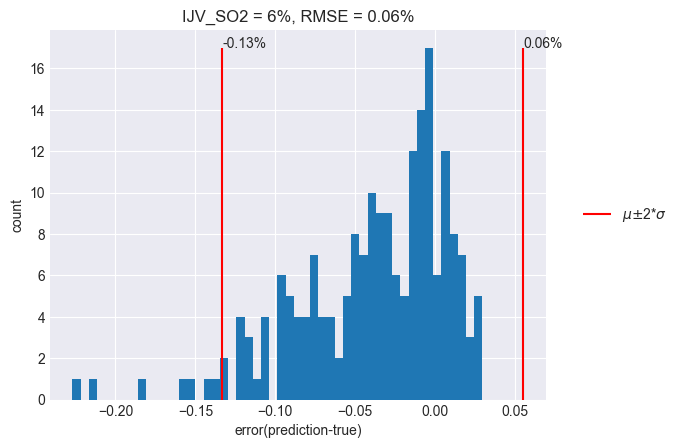

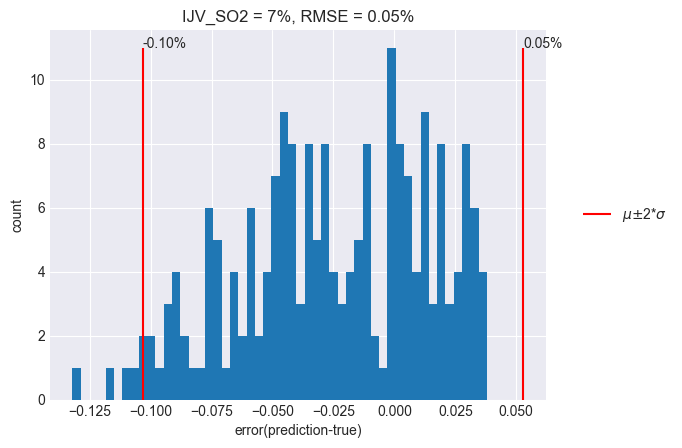

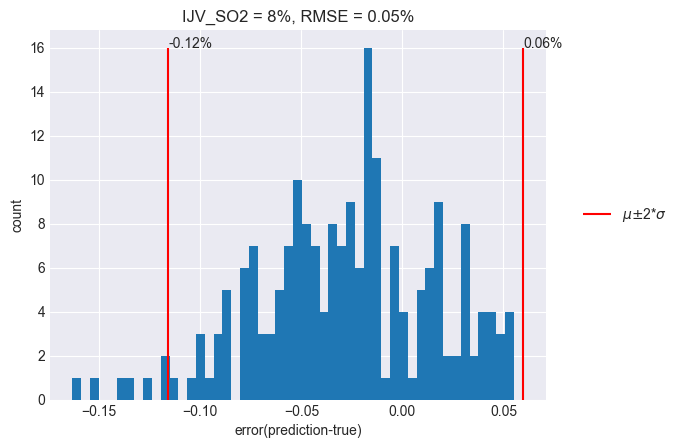

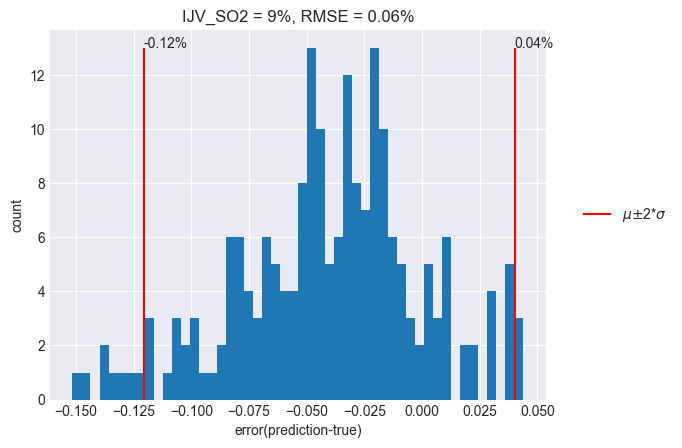

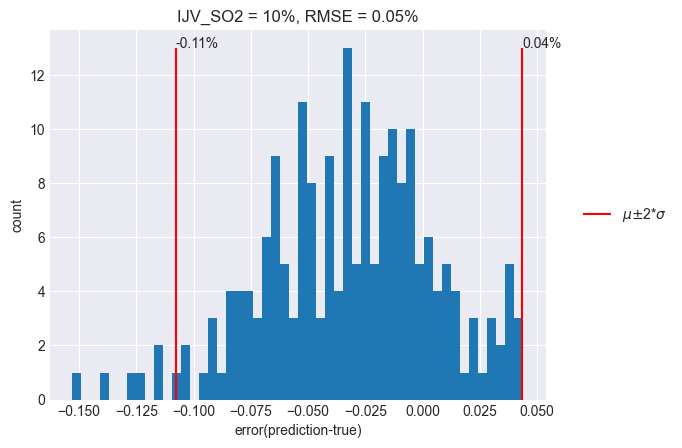

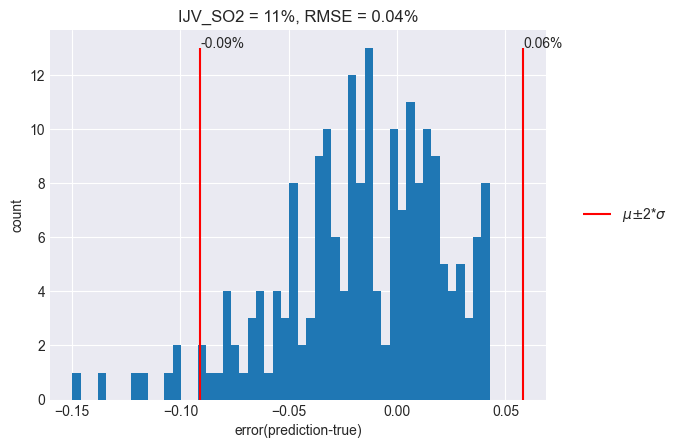

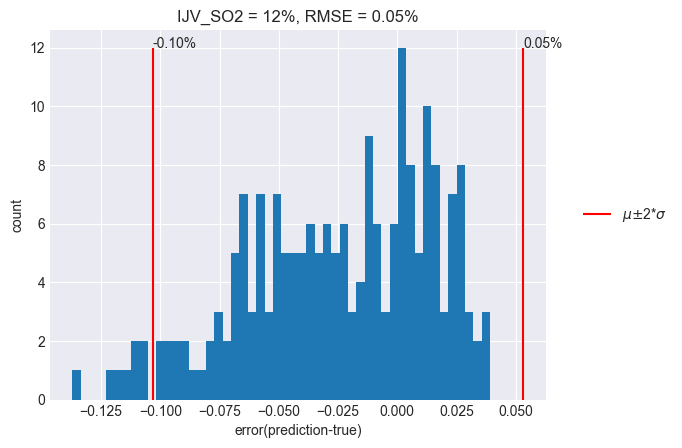

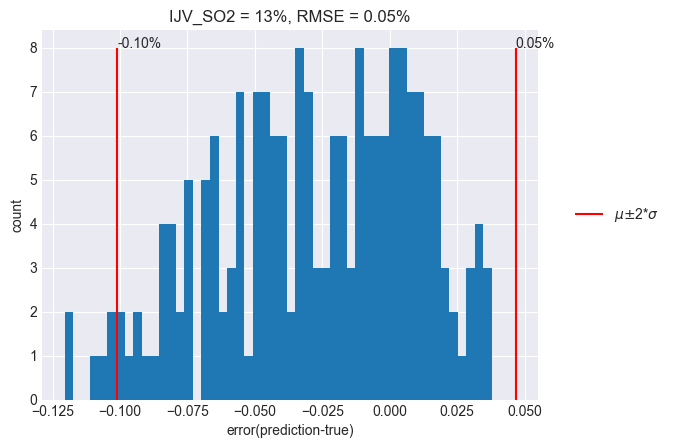

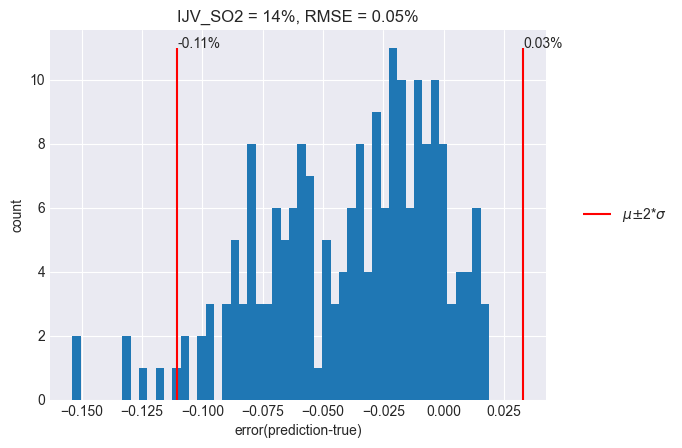

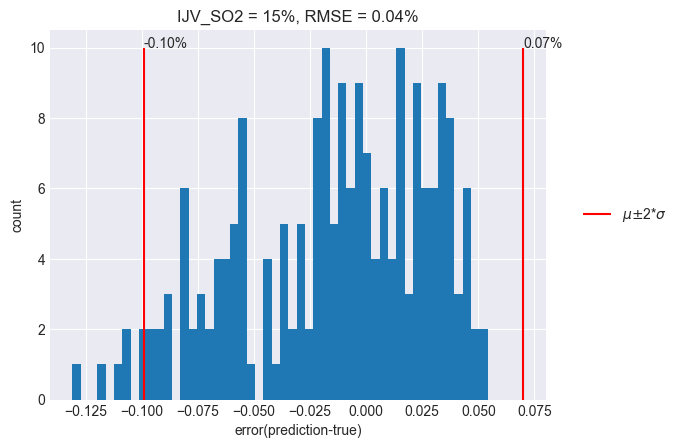

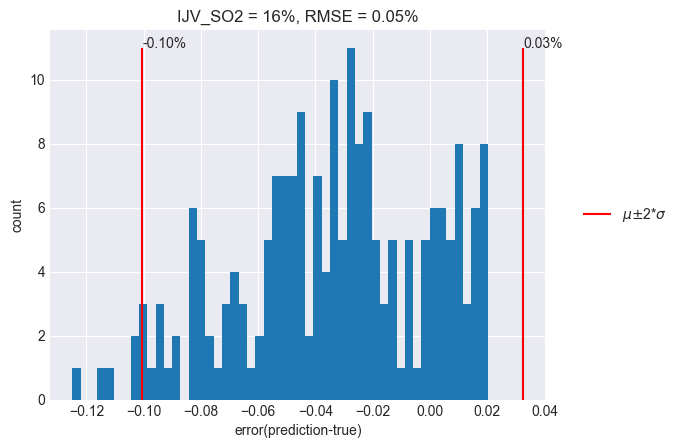

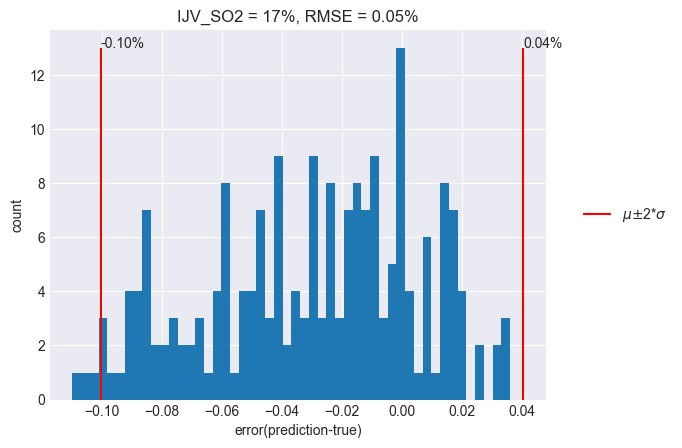

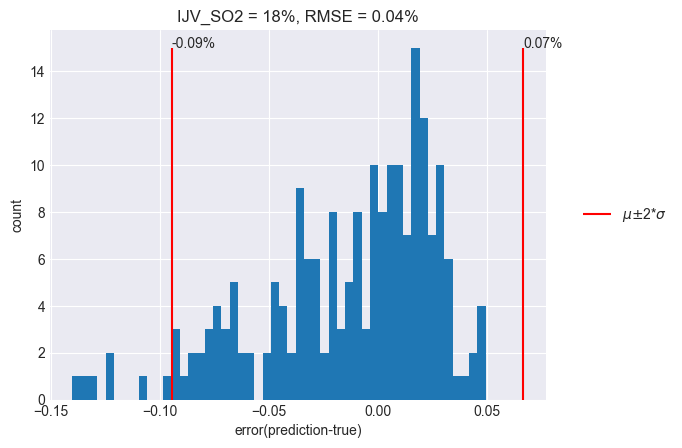

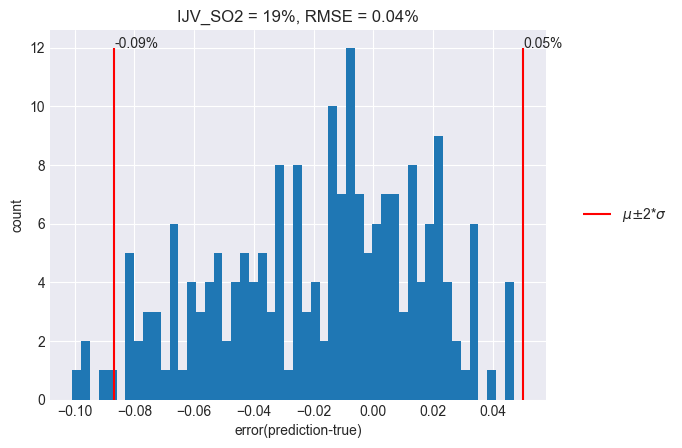

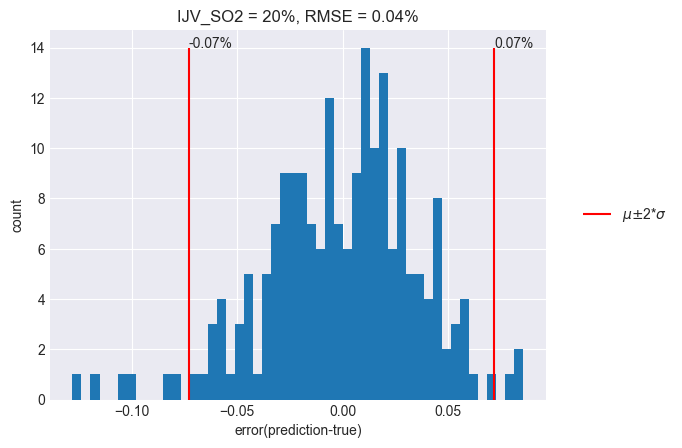

In [71]:
for key in table.keys():
    error = table[key]
    error = np.array(error)
    mean = np.mean(error)
    std = np.std(error)
    RMSE = np.sqrt(np.mean(np.square(error)))

    n,bin, pack = plt.hist(error, bins=50)
    plt.vlines([mean+2*std, mean-2*std], 0, max(n), 'r', label='$\mu$$\pm$2*$\sigma$')
    plt.text(mean+2*std, max(n), f'{mean+2*std:.2f}%')
    plt.text(mean-2*std, max(n), f'{mean-2*std:.2f}%')
    plt.xlabel('error(prediction-true)')
    plt.ylabel('count')
    plt.title(f'IJV_SO2 = {key}%, RMSE = {RMSE:.2f}%')
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
    plt.savefig(os.path.join("pic", subject, result_folder, f"{key}%_hist.png"), dpi=300, format='png', bbox_inches='tight')
    plt.show()